In [285]:
!pip install mapclassify

In [286]:
!pip install cartopy

In [287]:
# Common imports including dataframe management, mapping, file io, and helpers for extraction zips and tars
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import mapclassify

import seaborn as sns


import zipfile, tarfile
import os
import datetime
from pathlib import PurePath

# Bring in requests for making HTTP API calls
import requests as req

In [288]:
# NOAA's Space Weather Prediction Center (SPWC)
aurora_data_url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'

In [314]:
resp = req.get(aurora_data_url)

if resp.status_code != 200:
  print('Unable to fech Aurora data')
else:
  data = resp.json()
  aurora_df = pd.DataFrame(data)

aurora_df.head()

,Observation Time,Forecast Time,Data Format,coordinates,type
0,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 9]",MultiPoint
1,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint
2,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 13]",MultiPoint
3,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 16]",MultiPoint
4,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 20]",MultiPoint


In [315]:
# all the values are for current time
aurora_df['Observation Time']

,Observation Time
0,2025-11-06T23:41:00Z
1,2025-11-06T23:41:00Z
2,2025-11-06T23:41:00Z
3,2025-11-06T23:41:00Z
4,2025-11-06T23:41:00Z
...,...
65155,2025-11-06T23:41:00Z
65156,2025-11-06T23:41:00Z
65157,2025-11-06T23:41:00Z
65158,2025-11-06T23:41:00Z


In [291]:
aurora_df['coordinates']

,coordinates
0,"[0, -90, 9]"
1,"[0, -89, 0]"
2,"[0, -88, 13]"
3,"[0, -87, 17]"
4,"[0, -86, 21]"
...,...
65155,"[359, 86, 0]"
65156,"[359, 87, 0]"
65157,"[359, 88, 0]"
65158,"[359, 89, 0]"


In [316]:
# Looking at only the Northern Hemisphere
# and within the longitudinal ranges of United States (including Alaska), with some padding

min_lat, max_lat = 1, 90
min_long, max_long = 0, 360

In [317]:
# Explode coordinates into their own columns, makes it easier to query

split_columns = pd.DataFrame(aurora_df['coordinates'].tolist(), columns=['longitude', 'latitude', 'aurora'])
aurora_df = pd.concat([aurora_df, split_columns], axis=1)
aurora_df

,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
0,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -90, 9]",MultiPoint,0,-90,9
1,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -89, 0]",MultiPoint,0,-89,0
2,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -88, 13]",MultiPoint,0,-88,13
3,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -87, 16]",MultiPoint,0,-87,16
4,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, -86, 20]",MultiPoint,0,-86,20
...,...,...,...,...,...,...,...,...
65155,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [318]:
aurora_df = aurora_df[aurora_df['longitude'].isin(range(min_long, max_long+1)) & aurora_df['latitude'].isin(range(min_lat, max_lat + 1))]
aurora_df

,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,0,1,0
92,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,0,2,0
93,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,0,3,0
94,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,0,4,0
95,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,0,5,0
...,...,...,...,...,...,...,...,...
65155,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,359,86,0
65156,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,359,87,0
65157,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,359,88,0
65158,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,359,89,0


In [344]:
!rm -rf arctic_shape_data/

In [345]:
!curl -o arctic-shapefile.zip 'https://usicecenter.gov/File/DownloadArchive?prd=211062025'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2829k  100 2829k    0     0  3845k      0 --:--:-- --:--:-- --:--:-- 3843k


In [346]:
arctic_zipfile = zipfile.ZipFile('arctic-shapefile.zip')

dir_name = 'arctic_shape_data'
if not os.path.isdir(dir_name):
  os.mkdir(dir_name)
  arctic_zipfile.extractall(dir_name)


In [347]:
arctic_shpfile = 'nic_autoc2025310n_pl_a.shp'
# arctic_shpfile = 'ARCTIC251031.shp'
arctic_gdf = gpd.read_file(PurePath(dir_name, arctic_shpfile))
arctic_gdf

,ICECODE,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,CT99,1,3.659375e+04,1.075459e+07,"POLYGON ((162.47325 56.24786, 162.49326 56.242..."
1,CT99,2,3.137181e+05,9.310347e+08,"POLYGON ((-158.69 56.95422, -158.67795 56.9361..."
2,CT99,3,4.358774e+04,3.617475e+07,"POLYGON ((162.44973 57.75083, 162.46678 57.746..."
3,CT99,4,2.753282e+04,1.938524e+07,"POLYGON ((141.88499 51.59958, 141.88916 51.600..."
4,CT99,5,8.002634e+04,3.214013e+07,"POLYGON ((161.98581 58.0975, 161.98415 58.0916..."
...,...,...,...,...,...
66,CT99,67,1.843812e+05,4.277043e+08,"POLYGON ((52.16242 68.35997, 52.16486 68.36292..."
67,CT99,68,1.233151e+05,1.767369e+08,"POLYGON ((50.77667 68.34956, 50.80919 68.36833..."
68,CT99,69,1.291304e+06,2.284159e+09,"POLYGON ((-49.79347 64.33875, -49.80256 64.344..."
69,CT99,70,1.408866e+08,7.576398e+12,"POLYGON ((-157.95204 70.84506, -157.86607 70.9..."


<Axes: >

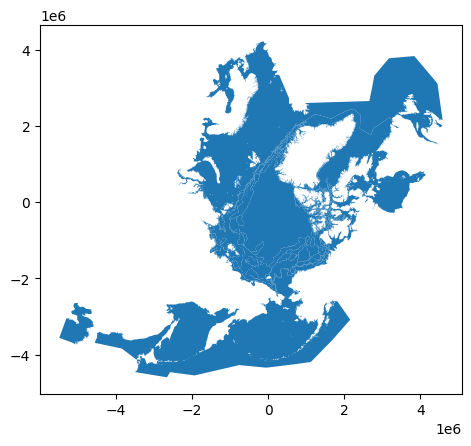

In [343]:
arctic_gdf.plot()

In [339]:
arctic_gdf.crs

<Projected CRS: PROJCS["WGS_1984_Stereographic_North_Pole",GEOGCS[ ...>
Name: WGS_1984_Stereographic_North_Pole
Axis Info [cartesian]:
- [south]: Easting (metre)
- [south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [300]:
# arctic_gdf = arctic_gdf.to_crs('EPSG:3995')

In [301]:
# arctic_gdf.plot()

In [322]:
longitudes = np.array(aurora_df['longitude'])
longitudes

array([  0,   0,   0, ..., 359, 359, 359])

In [323]:
np.mod(-longitudes, 360) - 180

array([-180, -180, -180, ..., -179, -179, -179])

In [304]:
aurora_df_copy = aurora_df.copy()

In [324]:
# Convert longitudes from [0, 360] to [180, -180]
aurora_df['longitude'] = np.mod( - np.array(aurora_df['longitude']), 360) -180

/tmp/ipython-input-3942286596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aurora_df['longitude'] = np.mod( - np.array(aurora_df['longitude']), 360) -180


In [325]:
aurora_df

,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora
91,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 1, 0]",MultiPoint,-180,1,0
92,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 2, 0]",MultiPoint,-180,2,0
93,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 3, 0]",MultiPoint,-180,3,0
94,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 4, 0]",MultiPoint,-180,4,0
95,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[0, 5, 0]",MultiPoint,-180,5,0
...,...,...,...,...,...,...,...,...
65155,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 86, 0]",MultiPoint,-179,86,0
65156,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 87, 0]",MultiPoint,-179,87,0
65157,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 88, 0]",MultiPoint,-179,88,0
65158,2025-11-06T23:41:00Z,2025-11-07T00:25:00Z,"[Longitude, Latitude, Aurora]","[359, 89, 0]",MultiPoint,-179,89,0


In [326]:
aurora_df.query('latitude == 0 & aurora > 0')

,Observation Time,Forecast Time,Data Format,coordinates,type,longitude,latitude,aurora


<Axes: >

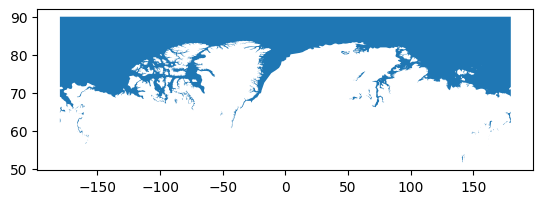

In [327]:
arctic_gdf.plot()

In [328]:
aurora_points = gpd.GeoDataFrame(aurora_df, geometry=gpd.points_from_xy(aurora_df.longitude, aurora_df.latitude))

In [329]:
from matplotlib.colors import LinearSegmentedColormap
def aurora_cmap():
  stops = {'red': [(0.00, 0.1725, 0.1725),
                      (0.50, 0.1725, 0.1725),
                      (1.00, 0.8353, 0.8353)],

              'green': [(0.00, 0.9294, 0.9294),
                        (0.50, 0.9294, 0.9294),
                        (1.00, 0.8235, 0.8235)],

              'blue': [(0.00, 0.3843, 0.3843),
                        (0.50, 0.3843, 0.3843),
                        (1.00, 0.6549, 0.6549)],

              'alpha': [(0.00, 0.0, 0.0),
                        (0.50, 1.0, 1.0),
                        (1.00, 1.0, 1.0)]}
  return LinearSegmentedColormap('aurora', stops)

<Axes: >

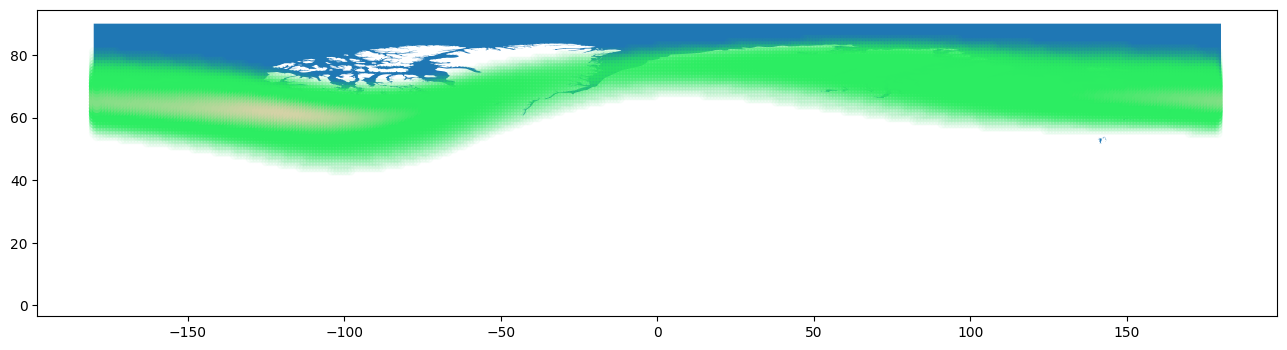

In [350]:
fig, ax = plt.subplots(1, figsize = (16, 9))
arctic_gdf.plot(ax=ax)

aurora_points.plot(ax=ax, cmap=aurora_cmap(), column='aurora')

In [340]:
arctic_gdf = arctic_gdf.to_crs('EPSG:3995')
arctic_gdf.crs

<Projected CRS: EPSG:3995>
Name: WGS 84 / Arctic Polar Stereographic
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
- bounds: (-180.0, 60.0, 180.0, 90.0)
Coordinate Operation:
- name: Arctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich